# Data and Imports

In [2]:
import xarray as xr

from weather_data_class import WeatherData

ds = xr.open_dataset('data_850/2022_850_SA_coarsen.nc')
ds.load()

<xarray.Dataset> Size: 197MB
Dimensions:    (time: 8760, latitude: 16, longitude: 32)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * longitude  (longitude) float32 128B 16.31 16.81 17.31 ... 30.81 31.31 31.81
  * latitude   (latitude) float32 64B -34.89 -34.39 -33.89 ... -27.89 -27.39
Data variables:
    q          (time, latitude, longitude) float64 36MB 0.007599 ... 0.009553
    t          (time, latitude, longitude) float64 36MB 282.4 282.5 ... 284.3
    u          (time, latitude, longitude) float64 36MB 14.09 13.71 ... 3.188
    v          (time, latitude, longitude) float64 36MB -0.8432 -1.022 ... 4.144
    w          (time, latitude, longitude) float64 36MB -0.002005 ... 0.1457
    wspd       (time, latitude, longitude) float32 18MB 14.12 13.75 ... 5.228
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-28 12:36:03 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
    wspd_units:   m/s

# Graph state representation

In [3]:
weather_data = WeatherData(ds, window_size=5, steps=3, auto=True, use_forcings=False)

Windowed...
Splitting...
Shuffling...


In [140]:
# Encoder functions

class MLPEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        """
        MLP to encode wind speed data from each state in the window.
        
        Args:
        input_dim (int): Dimension of the input feature (e.g., wind speed).
        hidden_dim (int): Dimension of the hidden layer.
        output_dim (int): Dimension of the output latent feature for each node.
        """
        super(MLPEncoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the MLP encoder.
        
        Args:
        x (torch.Tensor): Input tensor of shape [batch_size, latitude, longitude].
        
        Returns:
        torch.Tensor: Encoded tensor of shape [batch_size, latitude, longitude, output_dim].
        """
        # Flatten spatial dimensions and process through MLP
        batch_size, lat, lon = x.shape
        x_flat = x.view(batch_size, -1)  # Flatten lat, lon dimensions
        encoded = self.mlp(x_flat)
        # Reshape back to original spatial dimensions with new feature dim
        return encoded.view(batch_size, lat, lon, -1)
    
def generate_mesh(lat_size: np.ndarray = 16, lon_size: np.ndarray = 32) -> nx.Graph:
    """
    Generate a mesh based on latitude and longitude grid points using NetworkX.
    
    Args:
    lat (np.ndarray): Latitude values.
    lon (np.ndarray): Longitude values.
    connectivity (str): Either '4' or '8' to define the type of mesh connectivity (4 or 8 neighbors).
    
    Returns:
    nx.Graph: NetworkX graph representing the mesh structure.
    """
    # Create a graph and add nodes and edges for 4-connectivity (horizontal and vertical neighbors)
    G = nx.grid_2d_graph(lat_size, lon_size)

    # Add diagonal connections (8-connectivity)
    for i in range(lat_size):
        for j in range(lon_size):
            if i > 0 and j > 0:
                G.add_edge((i, j), (i-1, j-1))  # Top-left
            if i > 0 and j < lon_size - 1:
                G.add_edge((i, j), (i-1, j+1))  # Top-right
            if i < lat_size - 1 and j > 0:
                G.add_edge((i, j), (i+1, j-1))  # Bottom-left
            if i < lat_size - 1 and j < lon_size - 1:
                G.add_edge((i, j), (i+1, j+1))  # Bottom-right

    return G

def populate_mesh_with_features(mesh: nx.Graph, encoded_features: torch.Tensor) -> nx.Graph:
    """
    Populate the mesh with encoded wind speed features.
    
    Args:
    mesh (nx.Graph): The mesh containing nodes and edges.
    encoded_features (torch.Tensor): Encoded wind speed data of shape [latitude, longitude, feature_dim].
    
    Returns:
    nx.Graph: Updated mesh with node features.
    """

    batch, lat_size, lon_size, features = encoded_features.shape

    if batch == 1:
        # Squeeze to reduce dimensions to [lat_size, lon_size, feature_dim]
        encoded_features = encoded_features.squeeze(0) # Shape: [lat_size, lon_size, feature_dim]

        
        # Create node_value_dict with features as vectors
        node_value_dict = {(i, j): encoded_features[i, j].tolist() for i in range(lat_size) for j in range(lon_size)}
    else:
        # If batch > 1, handle appropriately
        for b in range(batch):
            for i in range(lat_size):
                for j in range(lon_size):
                    mesh.nodes[(i, j)]['value'] = encoded_features[b, i, j].tolist()  # Store as vector

    # Set node attributes
    nx.set_node_attributes(mesh, node_value_dict, name="value")

    return mesh

def create_meshes_for_window(window: torch.Tensor, encoder: nn.Module, lat: np.ndarray, lon: np.ndarray, encode: bool = True) -> list[dict]:
    """
    Create meshes for each state in the window and encode them.
    
    Args:
    window (torch.Tensor): Input window of shape [batch_size, window_size, latitude, longitude].
    encoder (nn.Module): The MLP encoder to encode wind speed data.
    lat (np.ndarray): Array of latitude values.
    lon (np.ndarray): Array of longitude values.
    connectivity (str): Mesh connectivity, either '4' or '8'.
    
    Returns:
    list[dict]: A list of meshes for each timestep in the window.
    """
    batch_size, window_size, lat_dim, lon_dim = window.shape
    meshes = []
    
    # Loop through each state in the window
    for t in range(window_size):
        wind_speed_state = window[:, t]  # Extract wind speed data at timestep t
        if encode:
            encoded_state = encoder(wind_speed_state)
        else:
            encoded_state = wind_speed_state.reshape(batch_size, lat_dim, lon_dim, 1)
        
        # Generate the mesh and populate it with features
        mesh = generate_mesh(lat, lon)
        populated_mesh = populate_mesh_with_features(mesh, encoded_state)
        meshes.append(populated_mesh)

    # print(f'Nr meshes: {len(meshes)}, representing shape {encoded_state.shape}')
    
    return meshes

def plot_mesh(meshes, lat_size: int = 16, lon_size: int = 32):
    """Plot multiple meshes as subplots.

    Args:
        meshes: List of mesh graphs.
        positions: List of positions for each mesh.
        subplots: Number of subplots in the grid.
    """

    positions = {}
    for i in range(lat_size):
        for j in range(lon_size):
            positions[(i, j)] = (j, i)

    num_meshes = len(meshes)
    subplots = num_meshes
    
    # Determine number of rows and columns for subplots
    rows = (num_meshes // subplots) + (num_meshes % subplots > 0)
    cols = min(num_meshes, subplots)
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    for i in range(num_meshes):
        node_colors = [meshes[i].nodes[node]['value'] for node in meshes[i].nodes]
        nx.draw(meshes[i], pos=positions, node_size=30, node_color=node_colors, cmap=plt.cm.viridis, edge_color='gray', ax=axs[i], with_labels=False)
        axs[i].set_title(f"Mesh {i + 1} with Diagonal Connections")
    
    # Hide any unused subplots
    for j in range(num_meshes, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Processing Functions

class MessagePassingLayer(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(MessagePassingLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim* 2, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, input_dim)
        )

    def forward(self, graph: nx.Graph, node_features: torch.Tensor, lon_size: int = 32) -> torch.Tensor:
        """
        Perform a single message-passing operation.

        Args:
        graph (nx.Graph): The graph representing the mesh.
        node_features (torch.Tensor): Tensor of shape [num_nodes, feature_dim] representing features of each node.

        Returns:
        torch.Tensor: Updated node features after message passing.
        """

        updated_features = torch.zeros_like(node_features) # torch.Size([512, 1])

        # print(updated_features[0].shape)
        
        for node in graph.nodes:
            neighbor_features = torch.stack(
                [node_features[i * lon_size + j] for (i, j) in graph.neighbors(node)],
                dim=0
            )
            
            mean_neighbor_features = torch.mean(neighbor_features, dim=0)

            i, j = node 
            single_index = i * lon_size + j  

            combined_features = torch.cat([node_features[single_index], mean_neighbor_features], dim=-1) # 1 x 2 tensor

            # print(combined_features, self.mlp(combined_features))
            # print("Shape of node feature:", node_features[single_index].shape)  
            # print("Shape of mean neighbor features:", mean_neighbor_features.shape)

            updated_features[single_index] = self.mlp(combined_features)

        return updated_features

class MultiRoundMessagePassing(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, num_rounds: int):
        super(MultiRoundMessagePassing, self).__init__()
        self.num_rounds = num_rounds
        self.message_passing_layers = nn.ModuleList(
            [MessagePassingLayer(input_dim if i == 0 else input_dim, input_dim) for i in range(num_rounds)]
        )
        self.final_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, graph: nx.Graph, node_features: torch.Tensor) -> torch.Tensor:
        """
        Perform multiple rounds of message passing with residual connections.

        Args:
        graph (nx.Graph): The graph representing the mesh.
        node_features (torch.Tensor): Initial node features of shape [num_nodes, feature_dim].

        Returns:
        torch.Tensor: Final updated node features after multiple rounds of message passing.
        """
        for layer in self.message_passing_layers:
            updated_features = layer(graph, node_features)
            node_features = node_features + updated_features  # Residual connection

        # Final transformation to output latent features

        return self.final_layer(node_features)

def process_meshes_with_message_passing(meshes: list[nx.Graph], processor: MultiRoundMessagePassing) -> list[torch.Tensor]:
    """
    Process the encoded meshes using multi-round message passing.

    Args:
    meshes (list[nx.Graph]): List of meshes created from the encoder.
    processor (MultiRoundMessagePassing): The message-passing processor module.

    Returns:
    list[torch.Tensor]: List of updated node features after message passing for each mesh.
    """
    processed_meshes = []
    for mesh in meshes:
        # Extract initial node features from the graph (populated by the encoder)
        node_features = torch.tensor([mesh.nodes[node]['value'] for node in mesh.nodes])

        # node_features = node_features.squeeze()
        # print(f'Node features shape: {node_features.shape}')
        
        # Perform message passing to update node features
        updated_node_features = processor(mesh, node_features)

        processed_mesh = updated_node_features.view(16, 32, 1)
        
        processed_meshes.append(processed_mesh)
    
    return processed_meshes

class MLPDecoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        """
        MLP to encode wind speed data from each state in the window.
        
        Args:
        input_dim (int): Dimension of the input feature (e.g., wind speed).
        hidden_dim (int): Dimension of the hidden layer.
        output_dim (int): Dimension of the output latent feature for each node.
        """
        super(MLPDecoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim * 5, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 512)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the MLP encoder.
        
        Args:
        x (torch.Tensor): Input tensor of shape [batch_size, latitude, longitude].
        
        Returns:
        torch.Tensor: Encoded tensor of shape [batch_size, latitude, longitude, output_dim].
        """
        # Flatten spatial dimensions and process through MLP
        _, lat, lon = x.shape
        x_flat = x.view(1, -1)  # Flatten lat, lon dimensions
        encoded = self.mlp(x_flat)

        # Reshape back to original spatial dimensions with new feature dim
        return encoded.view(lat, lon)
    

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder, decoder, and processor and move them to the GPU
encoder_shape = weather_data.dataset.latitude.size * weather_data.dataset.longitude.size
encoder = MLPEncoder(input_dim=encoder_shape, hidden_dim=encoder_shape, output_dim=encoder_shape).to(device)
decoder = MLPDecoder(input_dim=encoder_shape, hidden_dim=encoder_shape, output_dim=encoder_shape).to(device)
processor = MultiRoundMessagePassing(input_dim=1, hidden_dim=1, output_dim=1, num_rounds=3).to(device)

# Define the loss function and optimizer
criteria = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(processor.parameters()), lr=0.001)

def train(weather_data, num_epochs=50):
    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        processor.train()

        epoch_loss = 0

        for i in range(len(weather_data.X_train_t)):
            # Get the current training window and move to GPU
            input_window = weather_data.X_train_t[i:i+1].to(device)
            target_window = weather_data.y_train_t[i:i+1].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            encoded_meshes = create_meshes_for_window(input_window, encoder, 
                                                       weather_data.dataset.latitude.size, 
                                                       weather_data.dataset.longitude.size)
            processed_meshes = process_meshes_with_message_passing(encoded_meshes, processor)
            processed_meshes = torch.stack(processed_meshes)
            final_output = decoder(processed_meshes.squeeze())

            # Calculate loss
            loss = criteria(final_output, target_window)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average loss for the epoch
        avg_loss = epoch_loss / len(weather_data.X_train_t)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Train the model on the GPU
train(weather_data, num_epochs=1)


RuntimeError: shape '[1, 16, 32]' is invalid for input of size 2560

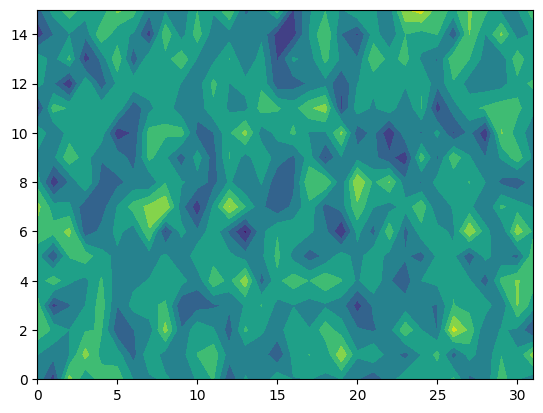

In [142]:
plt.contourf(prediction.detach().numpy())

# Test stuff

In [61]:
lat_size = 16
lon_size = 32
node_features = torch.tensor([encoded_meshes[0].nodes[node]['value'] for node in encoded_meshes[0].nodes])

print('Node features: ', node_features.shape)

updated_features = torch.zeros_like(node_features)

print('Updated features: ', updated_features.shape)

mp_layer = MessagePassingLayer(input_dim=1, output_dim=2)

for node in encoded_meshes[0].nodes:
    print(node)
    print(encoded_meshes[0].nodes[node]['value'])
    # print(encoded_meshes[0].neighbors(node))
    # for neighbor in encoded_meshes[0].neighbors(node):
    #     print(neighbor)
    #     print(encoded_meshes[0].nodes[neighbor]['value'])
    neighbor_features = torch.stack(
        [node_features[i * lon_size + j] for (i, j) in encoded_meshes[0].neighbors(node)],
        dim=0
    )
    print(neighbor_features)

    mean_neighbor_features = torch.mean(neighbor_features, dim=0)
    print(mean_neighbor_features)

    i, j = node  # Unpack the tuple node into its components
    single_index = i * lon_size + j  # Calculate the single index

    # Now index into the node_features tensor using the single index
    print(node_features[single_index])

    combined_features = torch.cat([node_features[single_index], mean_neighbor_features], dim=-1)

    output = mp_layer.mlp(combined_features)
    print(output)
    
    break

Node features:  torch.Size([512, 1])
Updated features:  torch.Size([512, 1])
(0, 0)
[-0.4423202574253082]
tensor([[-0.0322],
        [-0.2397],
        [-0.2185]])
tensor([-0.1635])
tensor([-0.4423])
tensor([-0.8760], grad_fn=<ViewBackward0>)


In [98]:
lat_size = 16
lon_size = 32

mp_layer = MessagePassingLayer(input_dim=1, output_dim=2)

updated_mesh = encoded_meshes[0].copy()

for node in encoded_meshes[0].nodes:
    print('Value: ', encoded_meshes[0].nodes[node]['value'])
    # for neighbor in encoded_meshes[0].neighbors(node):
    #     print(neighbor)
    #     print(encoded_meshes[0].nodes[neighbor]['value'])
    neighbor_features = torch.stack(
        [torch.tensor(encoded_meshes[0].nodes[neighbor]['value']) for neighbor in encoded_meshes[0].neighbors(node)],
        dim=0
    )

    mean_neighbor_features = torch.mean(neighbor_features, dim=0)

    print('Mean neighbor features: ', mean_neighbor_features)

    # # Now index into the node_features tensor using the single index

    combined_features = torch.cat([torch.tensor(updated_mesh.nodes[node]['value']), mean_neighbor_features], dim=-1)

    print('Combined: ', combined_features)

    updated_mesh.nodes[node]['value'] = mp_layer.mlp(combined_features)

    print('Output: ', updated_mesh)
    


Value:  [-0.009506039321422577]
Mean neighbor features:  tensor([-0.0563])
Combined:  tensor([-0.0095, -0.0563])
Output:  Graph with 512 nodes and 1906 edges
Value:  [0.06920531392097473]
Mean neighbor features:  tensor([-0.0353])
Combined:  tensor([ 0.0692, -0.0353])
Output:  Graph with 512 nodes and 1906 edges
Value:  [0.11846683919429779]
Mean neighbor features:  tensor([-0.0805])
Combined:  tensor([ 0.1185, -0.0805])
Output:  Graph with 512 nodes and 1906 edges
Value:  [0.054516807198524475]
Mean neighbor features:  tensor([0.0373])
Combined:  tensor([0.0545, 0.0373])
Output:  Graph with 512 nodes and 1906 edges
Value:  [0.20592349767684937]
Mean neighbor features:  tensor([0.0395])
Combined:  tensor([0.2059, 0.0395])
Output:  Graph with 512 nodes and 1906 edges
Value:  [0.012427318841218948]
Mean neighbor features:  tensor([0.0291])
Combined:  tensor([0.0124, 0.0291])
Output:  Graph with 512 nodes and 1906 edges
Value:  [-0.20661655068397522]
Mean neighbor features:  tensor([0.021

In [100]:
updated_mesh.nodes[(0, 0)]['value'], encoded_meshes[0].nodes[(0, 0)]['value']

(tensor([-0.8603], grad_fn=<ViewBackward0>), [-0.009506039321422577])